In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import numpy as np


import nltk
nltk.download('punkt')

train = pd.read_csv("~/Downloads/train.csv",  sep='\t')
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.set_option('max_colwidth', 100)
print(train.shape)

train.fillna('',inplace=True)
print(train.head())   
print(train.columns)


[nltk_data] Downloading package punkt to /home/cawinchan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
(984, 7)
       id  sentiment  \
0  7759_3          0   
1  3630_4          0   
2  9495_8          1   
3  8196_8          1   
4  7166_2          0   

                                                                                                review  \
0  The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Pr...   
1  It must be assumed that those who praised this film (\"the greatest filmed opera ever,\" didn't ...   
2  Superbly trashy and wondrously unpretentious 80's exploitation, hooray! The pre-credits opening ...   
3  I dont know why people think this is such a bad movie. Its got a pretty good plot, some good act...   
4  This movie could have been very good, but comes up way short. Cheesy special effects and so-so a...   

  Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  
0                                       

In [7]:

train['review'] = train.loc[:,'review':].astype(str).apply(lambda x: ''.join(x),axis=1)


In [8]:
train.drop(train.loc[:,'Unnamed: 3':],inplace=True,axis=1)

In [9]:
print(train.head())

       id  sentiment  \
0  7759_3          0   
1  3630_4          0   
2  9495_8          1   
3  8196_8          1   
4  7166_2          0   

                                                                                                review  
0  The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Pr...  
1  It must be assumed that those who praised this film (\"the greatest filmed opera ever,\" didn't ...  
2  Superbly trashy and wondrously unpretentious 80's exploitation, hooray! The pre-credits opening ...  
3  I dont know why people think this is such a bad movie. Its got a pretty good plot, some good act...  
4  This movie could have been very good, but comes up way short. Cheesy special effects and so-so a...  


In [10]:
zero = 0
one = 0
for row in train['sentiment']:
    if row == 0:
        zero += 1
        continue
    if row == 1:
        one += 1
        continue
    else:
        print(row,"missing response")
print("zero count",zero)
print("one count",one)
print("total is", zero+one)

train['sentiment'].describe()

zero count 510
one count 474
total is 984


count    984.000000
mean       0.481707
std        0.499919
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: sentiment, dtype: float64

In [11]:
import re

        
def cleantext(raw_html,troubleshoot=False):
    cleanr = re.compile('<.*?>')
    
    if troubleshoot:
            print(raw_html.head(10))
        
    for row in raw_html:
        cleanfromhtml = re.sub(cleanr, '', row)
        cleanfromnumbers_html = re.sub("\d+", "", cleanfromhtml)
        cleanfromnumbers_html_punc = re.sub(r'[^\w\s]','',cleanfromnumbers_html)
        train.loc[train['review'] == str(row), ['review']] = cleanfromnumbers_html_punc
        
    if troubleshoot:
        print(raw_html.head(10))
        
    return

cleantext(train['review'], troubleshoot=True)




0    The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Pr...
1    It must be assumed that those who praised this film (\"the greatest filmed opera ever,\" didn't ...
2    Superbly trashy and wondrously unpretentious 80's exploitation, hooray! The pre-credits opening ...
3    I dont know why people think this is such a bad movie. Its got a pretty good plot, some good act...
4    This movie could have been very good, but comes up way short. Cheesy special effects and so-so a...
5    I watched this video at a friend's house. I'm glad I did not waste money buying this one. The vi...
6    A friend of mine bought this film for £1, and even then it was grossly overpriced. Despite featu...
7    <br /><br />This movie is full of references. Like \"Mad Max II\", \"The wild one\" and many oth...
8    What happens when an army of wetbacks, towelheads, and Godless Eastern European commies gather t...
9    Although I generally do not like remakes believing

0    The film starts with a manager Nicholas Bell giving welcome investors Robert Carradine to Primal...
1    It must be assumed that those who praised this film the greatest filmed opera ever didnt I read ...
2    Superbly trashy and wondrously unpretentious s exploitation hooray The precredits opening sequen...
3    I dont know why people think this is such a bad movie Its got a pretty good plot some good actio...
4    This movie could have been very good but comes up way short Cheesy special effects and soso acti...
5    I watched this video at a friends house Im glad I did not waste money buying this one The video ...
6    A friend of mine bought this film for  and even then it was grossly overpriced Despite featuring...
7    This movie is full of references Like Mad Max II The wild one and many others The ladybugs face ...
8    What happens when an army of wetbacks towelheads and Godless Eastern European commies gather the...
9    Although I generally do not like remakes believing

In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1023479776483759325
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 145752064
locality {
  bus_id: 1
}
incarnation: 17974849182613766662
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
import tensorflow


from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras

import tensorflow as tf
import os


def rnn_network(vector, sentiment, x_test, y_test):
    sparse_model = Sequential()
    sparse_model.add(Dense(128, input_shape=(vector.shape[1],)))
    sparse_model.add(Dropout(0.2))
    sparse_model.add(Dense(100))
    sparse_model.add(Dropout(0.2))
    sparse_model.add(Dense(50))
    sparse_model.add(Dropout(0.2))
    sparse_model.add(Dense(10))
    sparse_model.add(Dropout(0.2))
    sparse_model.add(Dense(1, activation='sigmoid'))
    sparse_model.compile(optimizer='rmsprop',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])
    early_stop_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose=0, mode='auto')

    sparse_model.fit(vector, sentiment, epochs=20,
                     callbacks=[early_stop_callback, ])
    sparse_model.evaluate(x_test, y_test)
    validation = sparse_model.predict_classes(x_test)
    print(confusion_matrix(y_test, validation))
    print(classification_report(y_test, validation))
    return sparse_model



def tf_idf_vectoriser(sentences):
    vect_word = TfidfVectorizer(stop_words='english')
    sparse_matrix_word = vect_word.fit_transform(sentences)
    return sparse_matrix_word

def tf_idf_vectoriser2(sentences):
    vect_word = TfidfVectorizer(stop_words='english')
    sparse_matrix_word = vect_word.fit_transform(sentences)
    x_test = vect_word.fit(sentences)
    return sparse_matrix_word, x_test


def count_vectoriser(sentences):
    cvec = CountVectorizer(stop_words='english')
    sparse_matrix_count = cvec.fit_transform(sentences)
    return sparse_matrix_count
    
def hashing_Vectorizer(sentences):
    hv = HashingVectorizer(stop_words='english')
    sparse_matrix_count = hv.fit_transform(sentences)
    return sparse_matrix_count

def build_logistic_regression_model(vector, sentiment, x_test, y_test):
    lr = LogisticRegression()
    lr.fit(vector,sentiment)
    y_pred = lr.predict(x_test)
    confusion_matrix2 = confusion_matrix(y_test, y_pred)
    print(confusion_matrix2)
    print(classification_report(y_test, y_pred))
    logit_roc_auc = roc_auc_score(y_test, lr.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    return lr
    
def build_linear_SVC_model(vector, sentiment, x_test, y_test):
    lsvc = LinearSVC()
    lsvc.fit(vector,sentiment)
    y_pred = lsvc.predict(x_test)
    confusion_matrix2 = confusion_matrix(y_test, y_pred)
    print(confusion_matrix2)
    print(classification_report(y_test, y_pred))
    return lsvc

def run_model(vectoriser, model, description, counter):
    spar = vectoriser(description)
    x_train,x_test,y_train,y_test = train_test_split(spar,counter,test_size=0.33)
    model(x_train,y_train,x_test,y_test)
    return spar

def run_model2(vectoriser, model, description, counter):
    spar, x_test = vectoriser(description)
    x_train,x_test,y_train,y_test = train_test_split(spar,counter,test_size=0.33)
    model(x_train,y_train,x_test,y_test)
    return spar, x_test


def stacking_classifier(classifiers, meta_classifier, x_test,y_test):
    sclf = StackingClassifier(classifiers,meta_classifier)
    print('3-fold cross validation:\n')

    for clf, label in zip([classifiers.append(sclf)], [(str(i) for i in classifiers),"sclf"]):
    
        scores = model_selection.cross_val_score(clf, x_test, y_test, 
                                                  cv=3, scoring='accuracy')
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
              % (scores.mean(), scores.std(), label))


description = train['review'].tolist()
counter = train['sentiment'].tolist()
type(counter)
counter = np.array(counter)
description = np.array(description)



Epoch 1/20


 32/659 [>.............................] - ETA: 34s - loss: 0.6932 - acc: 0.4688

288/659 [============>.................] - ETA: 2s - loss: 0.6778 - acc: 0.5694 

576/659 [=========================>....] - ETA: 0s - loss: 0.6411 - acc: 0.6441

659/659 [==============================] - 2s 3ms/step - loss: 0.6297 - acc: 0.6616


Epoch 2/20
 32/659 [>.............................] - ETA: 0s - loss: 0.2059 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 0.1301 - acc: 0.9861

576/659 [=========================>....] - ETA: 0s - loss: 0.0943 - acc: 0.9878

659/659 [==============================] - 0s 199us/step - loss: 0.0882 - acc: 0.9894


Epoch 3/20
 32/659 [>.............................] - ETA: 0s - loss: 0.0037 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 0.0031 - acc: 1.0000

576/659 [=========================>....] - ETA: 0s - loss: 0.0033 - acc: 1.0000

659/659 [==============================] - 0s 206us/step - loss: 0.0036 - acc: 1.0000


Epoch 4/20
 32/659 [>.............................] - ETA: 0s - loss: 0.0024 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 1.0000

576/659 [=========================>....] - ETA: 0s - loss: 0.0010 - acc: 1.0000

659/659 [==============================] - 0s 203us/step - loss: 9.7242e-04 - acc: 1.0000


Epoch 5/20
 32/659 [>.............................] - ETA: 0s - loss: 1.3133e-04 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 8.5764e-04 - acc: 1.0000

576/659 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 1.0000    

659/659 [==============================] - 0s 209us/step - loss: 0.0012 - acc: 1.0000


Epoch 6/20
 32/659 [>.............................] - ETA: 0s - loss: 1.2781e-05 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 5.6316e-05 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 9.3171e-05 - acc: 1.0000

659/659 [==============================] - 0s 208us/step - loss: 1.1032e-04 - acc: 1.0000


Epoch 7/20
 32/659 [>.............................] - ETA: 0s - loss: 0.0030 - acc: 1.0000

256/659 [==========>...................] - ETA: 0s - loss: 6.3390e-04 - acc: 1.0000

512/659 [======================>.......] - ETA: 0s - loss: 3.2097e-04 - acc: 1.0000

659/659 [==============================] - 0s 214us/step - loss: 2.5160e-04 - acc: 1.0000


Epoch 8/20
 32/659 [>.............................] - ETA: 0s - loss: 3.5114e-06 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 9.1168e-06 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 1.5556e-05 - acc: 1.0000

659/659 [==============================] - 0s 219us/step - loss: 1.3987e-05 - acc: 1.0000


Epoch 9/20
 32/659 [>.............................] - ETA: 0s - loss: 1.7253e-06 - acc: 1.0000

256/659 [==========>...................] - ETA: 0s - loss: 1.8838e-06 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 3.7689e-06 - acc: 1.0000

659/659 [==============================] - 0s 240us/step - loss: 3.8474e-05 - acc: 1.0000


Epoch 10/20
 32/659 [>.............................] - ETA: 0s - loss: 9.8272e-05 - acc: 1.0000

256/659 [==========>...................] - ETA: 0s - loss: 1.3558e-05 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 7.3995e-06 - acc: 1.0000

659/659 [==============================] - 0s 244us/step - loss: 5.9290e-06 - acc: 1.0000


Epoch 11/20
 32/659 [>.............................] - ETA: 0s - loss: 1.0855e-07 - acc: 1.0000

256/659 [==========>...................] - ETA: 0s - loss: 6.7878e-07 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 6.7774e-07 - acc: 1.0000

659/659 [==============================] - 0s 249us/step - loss: 4.2028e-06 - acc: 1.0000


Epoch 12/20
 32/659 [>.............................] - ETA: 0s - loss: 1.1020e-07 - acc: 1.0000

256/659 [==========>...................] - ETA: 0s - loss: 1.8390e-06 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 1.0364e-06 - acc: 1.0000

659/659 [==============================] - 0s 259us/step - loss: 9.8334e-07 - acc: 1.0000


Epoch 13/20
 32/659 [>.............................] - ETA: 0s - loss: 1.1826e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.7292e-07 - acc: 1.0000

448/659 [===================>..........] - ETA: 0s - loss: 1.7857e-07 - acc: 1.0000

659/659 [==============================] - 0s 256us/step - loss: 5.3540e-06 - acc: 1.0000


Epoch 14/20
 32/659 [>.............................] - ETA: 0s - loss: 1.2703e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.1456e-07 - acc: 1.0000

448/659 [===================>..........] - ETA: 0s - loss: 1.4932e-07 - acc: 1.0000

659/659 [==============================] - 0s 254us/step - loss: 1.3801e-07 - acc: 1.0000


Epoch 15/20
 32/659 [>.............................] - ETA: 0s - loss: 1.1213e-07 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 1.5087e-04 - acc: 1.0000

576/659 [=========================>....] - ETA: 0s - loss: 7.5748e-05 - acc: 1.0000

659/659 [==============================] - 0s 204us/step - loss: 6.6435e-05 - acc: 1.0000


Epoch 16/20
 32/659 [>.............................] - ETA: 0s - loss: 1.0880e-07 - acc: 1.0000

320/659 [=============>................] - ETA: 0s - loss: 2.1509e-07 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 1.6497e-07 - acc: 1.0000

659/659 [==============================] - 0s 186us/step - loss: 1.6061e-07 - acc: 1.0000


Epoch 17/20
 32/659 [>.............................] - ETA: 0s - loss: 2.4432e-07 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 1.6701e-07 - acc: 1.0000

576/659 [=========================>....] - ETA: 0s - loss: 1.4977e-07 - acc: 1.0000

659/659 [==============================] - 0s 196us/step - loss: 1.4805e-07 - acc: 1.0000


Epoch 18/20
 32/659 [>.............................] - ETA: 0s - loss: 1.0720e-07 - acc: 1.0000

320/659 [=============>................] - ETA: 0s - loss: 3.7047e-07 - acc: 1.0000

640/659 [============================>.] - ETA: 0s - loss: 2.4084e-07 - acc: 1.0000

659/659 [==============================] - 0s 184us/step - loss: 2.3702e-07 - acc: 1.0000


 32/325 [=>............................] - ETA: 0s

325/325 [==============================] - 0s 150us/step


[[143  22]
 [ 50 110]]
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       165
           1       0.83      0.69      0.75       160

   micro avg       0.78      0.78      0.78       325
   macro avg       0.79      0.78      0.78       325
weighted avg       0.79      0.78      0.78       325



/home/cawinchan/anaconda3/envs/new_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[142  20]
 [ 58 105]]
              precision    recall  f1-score   support

           0       0.71      0.88      0.78       162
           1       0.84      0.64      0.73       163

   micro avg       0.76      0.76      0.76       325
   macro avg       0.77      0.76      0.76       325
weighted avg       0.78      0.76      0.76       325



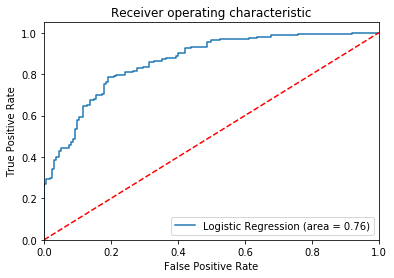

[[133  27]
 [ 41 124]]
              precision    recall  f1-score   support

           0       0.76      0.83      0.80       160
           1       0.82      0.75      0.78       165

   micro avg       0.79      0.79      0.79       325
   macro avg       0.79      0.79      0.79       325
weighted avg       0.79      0.79      0.79       325



In [14]:
rnn, x_test5 = run_model2(tf_idf_vectoriser2,rnn_network,description,counter)

lr, x_test4 = run_model2(tf_idf_vectoriser2,build_logistic_regression_model,description,counter)
svc, x_test3 = run_model2(tf_idf_vectoriser2,build_linear_SVC_model,description,counter)

#run_model(count_vectoriser,build_logistic_regression_model,description,counter)
#run_model(count_vectoriser,build_linear_SVC_model,description,counter)

#run_model(hashing_Vectorizer,build_logistic_regression_model,description,counter)
#run_model(hashing_Vectorizer,build_linear_SVC_model,description,counter)

[[147   0]
 [169   9]]
              precision    recall  f1-score   support

           0       0.47      1.00      0.63       147
           1       1.00      0.05      0.10       178

   micro avg       0.48      0.48      0.48       325
   macro avg       0.73      0.53      0.37       325
weighted avg       0.76      0.48      0.34       325



[[141  47]
 [ 13 124]]
              precision    recall  f1-score   support

           0       0.92      0.75      0.82       188
           1       0.73      0.91      0.81       137

   micro avg       0.82      0.82      0.82       325
   macro avg       0.82      0.83      0.81       325
weighted avg       0.84      0.82      0.82       325



/home/cawinchan/anaconda3/envs/new_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


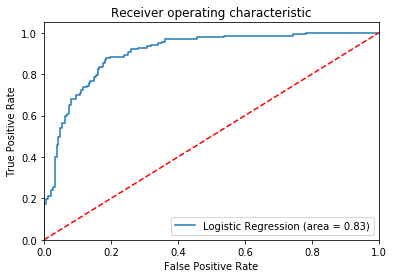

[[114  52]
 [ 43 116]]
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       166
           1       0.69      0.73      0.71       159

   micro avg       0.71      0.71      0.71       325
   macro avg       0.71      0.71      0.71       325
weighted avg       0.71      0.71      0.71       325



[[129  30]
 [ 89  77]]
              precision    recall  f1-score   support

           0       0.59      0.81      0.68       159
           1       0.72      0.46      0.56       166

   micro avg       0.63      0.63      0.63       325
   macro avg       0.66      0.64      0.62       325
weighted avg       0.66      0.63      0.62       325



/home/cawinchan/anaconda3/envs/new_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer


def build_MultinomialNB(vector, sentiment, x_test, y_test):
    nb = MultinomialNB().fit(vector,sentiment)
    y_pred = nb.predict(x_test)
    confusion_matrix2 = confusion_matrix(y_test, y_pred)
    print(confusion_matrix2)
    print(classification_report(y_test, y_pred))
    return nb

def build_KNeighborsClassifier(description, counter, x_test, y_test):
    kn = KNeighborsClassifier().fit(description,counter)
    y_pred = kn.predict(x_test)
    confusion_matrix2 = confusion_matrix(y_test, y_pred)
    print(confusion_matrix2)
    print(classification_report(y_test, y_pred))
    return kn

def build_RandomForestClassifier(description, counter, x_test, y_test):
    rf = RandomForestClassifier().fit(description,counter)
    y_pred = rf.predict(x_test)
    confusion_matrix2 = confusion_matrix(y_test, y_pred)
    print(confusion_matrix2)
    print(classification_report(y_test, y_pred))
    return rf




cv = CountVectorizer()   
x_train_transformed = cv.fit_transform(description)


td_trans = TfidfTransformer()
sparse5 = td_trans.fit_transform(x_train_transformed)

train_x, test_x, train_y, test_y = train_test_split(sparse5, counter, test_size=0.33)

nb = build_MultinomialNB(train_x,train_y,test_x,test_y)

sparse2, x_test6 = tf_idf_vectoriser2(description)
train_x, test_x, train_y, test_y = train_test_split(sparse2, counter, test_size=0.33)

lr2 = build_logistic_regression_model(train_x,train_y, test_x,test_y)

kn, x_test2 = run_model2(tf_idf_vectoriser2,build_KNeighborsClassifier,description,counter)

rf, x_test1 = run_model2(tf_idf_vectoriser2,build_RandomForestClassifier,description,counter)




In [18]:
from scipy import sparse

sparse_matrix_combined = sparse.hstack([lr, svc])
test_x_combined = sparse.hstack([x_test4, x_test3])
print(sparse_matrix_combined.shape)


reviews = train['review']
counter1 = train['sentiment']

train_x, test_x, train_y, test_y = train_test_split(sparse_matrix_combined, counter, test_size=0.33)

rnn_network(train_x,train_y,test_x,test_y)

(984, 42426)


Epoch 1/20


 32/659 [>.............................] - ETA: 9s - loss: 0.6940 - acc: 0.4688

 96/659 [===>..........................] - ETA: 3s - loss: 0.6976 - acc: 0.4375

160/659 [======>.......................] - ETA: 2s - loss: 0.6795 - acc: 0.5125

224/659 [=========>....................] - ETA: 1s - loss: 0.6719 - acc: 0.5580

288/659 [============>.................] - ETA: 1s - loss: 0.6575 - acc: 0.5868

352/659 [===============>..............] - ETA: 0s - loss: 0.6431 - acc: 0.6136

416/659 [=================>............] - ETA: 0s - loss: 0.6206 - acc: 0.6466

480/659 [====================>.........] - ETA: 0s - loss: 0.6127 - acc: 0.6542

544/659 [=======================>......] - ETA: 0s - loss: 0.5996 - acc: 0.6691

608/659 [==========================>...] - ETA: 0s - loss: 0.5878 - acc: 0.6842

659/659 [==============================] - 1s 2ms/step - loss: 0.5840 - acc: 0.6874


Epoch 2/20
 32/659 [>.............................] - ETA: 0s - loss: 0.0796 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 0.0855 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 0.0692 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 0.0618 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 0.0638 - acc: 0.9965

352/659 [===============>..............] - ETA: 0s - loss: 0.0582 - acc: 0.9972

416/659 [=================>............] - ETA: 0s - loss: 0.0607 - acc: 0.9952

480/659 [====================>.........] - ETA: 0s - loss: 0.0543 - acc: 0.9958

544/659 [=======================>......] - ETA: 0s - loss: 0.0497 - acc: 0.9963

608/659 [==========================>...] - ETA: 0s - loss: 0.0473 - acc: 0.9951

659/659 [==============================] - 1s 1ms/step - loss: 0.0487 - acc: 0.9924


Epoch 3/20
 32/659 [>.............................] - ETA: 0s - loss: 0.0109 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 0.0080 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 0.0056 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 0.0043 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 0.0044 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 0.0041 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 0.0037 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 0.0034 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 0.0032 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 0.0031 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 0.0030 - acc: 1.0000


Epoch 4/20
 32/659 [>.............................] - ETA: 0s - loss: 7.4288e-04 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 5.3463e-04 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 5.0764e-04 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 4.5462e-04 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 6.6316e-04 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 6.5318e-04 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 6.8296e-04 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 6.2857e-04 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 5.7096e-04 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 5.3401e-04 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 5.7940e-04 - acc: 1.0000


Epoch 5/20
 32/659 [>.............................] - ETA: 0s - loss: 2.3316e-04 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 5.6252e-04 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 4.9747e-04 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 3.9171e-04 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 3.2370e-04 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 2.8987e-04 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 2.6539e-04 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 2.4637e-04 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 3.0247e-04 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 2.7218e-04 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 2.5876e-04 - acc: 1.0000


Epoch 6/20
 32/659 [>.............................] - ETA: 0s - loss: 7.5655e-06 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 1.1994e-04 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 8.2854e-05 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 8.6714e-05 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 7.1565e-05 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 7.5146e-05 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 6.9148e-05 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 9.1738e-05 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 8.2520e-05 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 7.8438e-05 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 7.5512e-05 - acc: 1.0000


Epoch 7/20
 32/659 [>.............................] - ETA: 0s - loss: 2.3648e-05 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 2.1868e-05 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 1.6525e-05 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.2380e-05 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 1.1169e-05 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 2.9005e-05 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 2.4681e-05 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 6.6641e-05 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 8.2994e-05 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 7.6515e-05 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 7.0652e-05 - acc: 1.0000


Epoch 8/20
 32/659 [>.............................] - ETA: 0s - loss: 3.9332e-07 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 3.7860e-06 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 1.9079e-05 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.7250e-05 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 1.3457e-05 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 1.1073e-05 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 9.4825e-06 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 8.2504e-06 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 7.3615e-06 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 6.6312e-06 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 6.1267e-06 - acc: 1.0000


Epoch 9/20


 32/659 [>.............................] - ETA: 0s - loss: 3.6698e-06 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 2.7653e-06 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 2.0674e-06 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.9581e-06 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 1.5507e-06 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 1.3444e-06 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 1.3866e-06 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 2.0317e-06 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 1.9122e-06 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 1.7521e-06 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 1.6536e-06 - acc: 1.0000


Epoch 10/20


 32/659 [>.............................] - ETA: 0s - loss: 1.5411e-07 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 3.8696e-07 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 6.6547e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 6.6804e-04 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 5.7274e-04 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 4.6864e-04 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 3.9663e-04 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 3.4383e-04 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 3.0340e-04 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 2.7500e-04 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 2.5374e-04 - acc: 1.0000


Epoch 11/20
 32/659 [>.............................] - ETA: 0s - loss: 2.0097e-07 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 2.0770e-07 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 2.4362e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 2.0921e-07 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 5.5658e-07 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 5.7568e-07 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 5.0411e-07 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 6.2168e-06 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 5.5022e-06 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 5.9599e-06 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 5.5567e-06 - acc: 1.0000


Epoch 12/20
 32/659 [>.............................] - ETA: 0s - loss: 4.7365e-07 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 2.9372e-07 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 2.2976e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 2.7125e-07 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 2.3771e-07 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 1.3235e-04 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 1.1200e-04 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 9.7133e-05 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 8.5757e-05 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 7.6741e-05 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 7.0811e-05 - acc: 1.0000


Epoch 13/20
 32/659 [>.............................] - ETA: 0s - loss: 1.0900e-07 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 1.2675e-07 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 1.2634e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.2240e-07 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 4.1018e-07 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 3.5933e-07 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 3.3692e-07 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 3.7010e-07 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 3.4429e-07 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 3.6122e-07 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 3.4476e-07 - acc: 1.0000


Epoch 14/20
 32/659 [>.............................] - ETA: 0s - loss: 1.1201e-07 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 1.1161e-07 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 1.1196e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.1094e-07 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 1.1069e-07 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 4.0168e-06 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 3.4181e-06 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 7.8237e-06 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 1.6278e-05 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 1.4576e-05 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 1.3457e-05 - acc: 1.0000


Epoch 15/20
 32/659 [>.............................] - ETA: 0s - loss: 1.1141e-07 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 1.1000e-07 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 1.2523e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.2051e-07 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 1.1788e-07 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 1.1638e-07 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 1.1828e-07 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 1.1709e-07 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 1.1614e-07 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 1.1526e-07 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 1.8122e-07 - acc: 1.0000


Epoch 16/20
 32/659 [>.............................] - ETA: 0s - loss: 1.0780e-07 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 1.0860e-07 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 1.0876e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.0892e-07 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 2.3635e-07 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 2.1330e-07 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 1.9718e-07 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 1.8558e-07 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 1.7661e-07 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 1.6953e-07 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 1.6473e-07 - acc: 1.0000


Epoch 17/20


 32/659 [>.............................] - ETA: 0s - loss: 1.0900e-07 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 1.6214e-07 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 1.4125e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.3738e-07 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 1.3140e-07 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 1.2722e-07 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 1.2465e-07 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 1.2272e-07 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 1.2111e-07 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 1.1968e-07 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 1.1897e-07 - acc: 1.0000


Epoch 18/20
 32/659 [>.............................] - ETA: 0s - loss: 1.0960e-07 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 1.0940e-07 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 1.1109e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.1608e-07 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 1.1484e-07 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 1.1406e-07 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 1.1333e-07 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 5.7689e-07 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 5.2269e-07 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 4.8380e-07 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 4.5465e-07 - acc: 1.0000


Epoch 19/20


 32/659 [>.............................] - ETA: 0s - loss: 1.0960e-07 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 1.1746e-07 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 1.1408e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.1314e-07 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 1.1235e-07 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 1.1158e-07 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 1.1100e-07 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 1.4949e-07 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 1.5257e-07 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 1.4792e-07 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 1.4662e-07 - acc: 1.0000


Epoch 20/20


 32/659 [>.............................] - ETA: 0s - loss: 1.0960e-07 - acc: 1.0000

 96/659 [===>..........................] - ETA: 0s - loss: 1.0840e-07 - acc: 1.0000

160/659 [======>.......................] - ETA: 0s - loss: 1.0828e-07 - acc: 1.0000

224/659 [=========>....................] - ETA: 0s - loss: 1.1185e-07 - acc: 1.0000

288/659 [============>.................] - ETA: 0s - loss: 1.1102e-07 - acc: 1.0000

352/659 [===============>..............] - ETA: 0s - loss: 1.1104e-07 - acc: 1.0000

416/659 [=================>............] - ETA: 0s - loss: 1.1105e-07 - acc: 1.0000

480/659 [====================>.........] - ETA: 0s - loss: 1.1106e-07 - acc: 1.0000

544/659 [=======================>......] - ETA: 0s - loss: 1.1068e-07 - acc: 1.0000

608/659 [==========================>...] - ETA: 0s - loss: 1.1038e-07 - acc: 1.0000

659/659 [==============================] - 1s 1ms/step - loss: 1.1042e-07 - acc: 1.0000


 32/325 [=>............................] - ETA: 0s

192/325 [================>.............] - ETA: 0s

325/325 [==============================] - 0s 531us/step


[[129  36]
 [ 33 127]]
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       165
           1       0.78      0.79      0.79       160

   micro avg       0.79      0.79      0.79       325
   macro avg       0.79      0.79      0.79       325
weighted avg       0.79      0.79      0.79       325



In [126]:
from keras.preprocessing.text import Tokenizer


tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True,
                          split=" ",
                          char_level=False)
    tokenizer.fit_on_texts(summarized_sentences)

In [16]:
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import text_to_word_sequence
import fasttext


# list comprehension style
def keras_tokeniser(sentences):
    for sentence in sentences:
        text_to_word_sequence(sentence)
    return sentences

def size_of_vector_and_n_features_finder(df, model):
    n_sample_size = len(df)
    print(n_sample_size)
    number_of_model_words = len(model.words)
    size_of_vector = number_of_model_words * model.dim
    n_features = int(size_of_vector / n_sample_size)
    return n_sample_size, n_features

def fasttext_vectoriser_skipgram(data):
    model = fasttext.skipgram(data, 'model', dim=200)
    n_sample_size, n_features = size_of_vector_and_n_features_finder(data, model)
    vector_list = []
    for word in model.words:
        vector_list.append(model[word])
    myarray = np.asarray(vector_list)
    myarray = np.pad(myarray, (1), 'constant', constant_values=0)
    myarray = myarray.reshape(n_sample_size, n_features)
    return myarray


train_x, test_x, train_y, test_y = train_test_split(description, counter, test_size=0.33)
tokens = keras_tokeniser(train['review'])
for x in tokens:
    skip = fasttext_vectoriser_skipgram(x)

lr2 = build_logistic_regression_model(skip,train_y,test_x,test_y)

ValueError: fastText: cannot load The film starts with a manager Nicholas Bell giving welcome investors Robert Carradine to Primal Park  A secret project mutating a primal animal using fossilized DNA like Jurassik Park and some scientists resurrect one of natures most fearsome predators the Sabretooth tiger or Smilodon  Scientific ambition turns deadly however and when the high voltage fence is opened the creature escape and begins savagely stalking its prey  the human visitors  tourists and scientificMeanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large prehistorical animals which are deadlier and bigger  In addition  a security agent Stacy Haiduk and her mate Brian Wimmer fight hardly against the carnivorous Smilodons The Sabretooths themselves  of course are the real star stars and they are astounding terrifyingly though not convincing The giant animals savagely are stalking its prey and the group run afoul and fight against one natures most fearsome predators Furthermore a third Sabretooth more dangerous and slow stalks its victimsThe movie delivers the goods with lots of blood and gore as beheading hairraising chillsfull of scares when the Sabretooths appear with mediocre special effectsThe story provides exciting and stirring entertainment but it results to be quite boring The giant animals are majority made by computer generator and seem totally lousy Middling performances though the players reacting appropriately to becoming foodActors give vigorously physical performances dodging the beasts runningbound and leaps or dangling over walls  And it packs a ridiculous final deadly scene No for small kids by realisticgory and violent attack scenes  Other films about Sabretooths or Smilodon are the following  Sabretoothby James R Hickox with Vanessa Angel David Keith and John Rhys Davies and the much better  BC by Roland Emmerich with with Steven Strait Cliff Curtis and Camilla Belle This motion picture filled with bloody moments is badly directed by George Miller and with no originality because takes too many elements from previous films Miller is an Australian director usually working for television Tidal wave Journey to the center of the earth and many others and occasionally for cinema  The man from Snowy river Zeus and RoxanneRobinson Crusoe  Rating  Below average bottom of barrel